# About this Project Code:
### Code is divided into separate parts according to each Objective of the project
###### Objectives:
1. Get the Data Using API from https://developer.nytimes.com/ for Books.
    - For the purpose of this project, we download data only for 3 years for 4 different categories of books from the API
    - Save the data in json file on local hardrive for later storing it in MONGODB
2. Retrieve the downloaded data and store it in MONGODB.
    - Get the downloaded data stored on the local harddrive
    - Make a connection with MONGODB running on Virtual Machine
    - Create a new Database named "NYT_BestSeller"
    - Insert all the json book items based on Weekly Best Seller Collection in the MONGODB
    - Check if all the items are inserted
3. Get the data from MONGODB NYT_BestSeller DB and Structurise it for further project purpose.
    - Get the data from the MONGODB
    - Extract all data and store it in as a dataframe
    - Clean it by removing unnecessary columns, and check missing values and dealing with duplicates.
    - Final cleaned data is ready and saved on local harddrive for further use.
4. Store the cleaned data into PostGreSQL
    - Get the cleaned data from harddrive
    - Make a connection with PostGreSQL running on Virtual Machine
    - Create a new Database NYT_BestSeller for this project purpose
    - Create new Table in this newly created Database
    - Store the structured data to this newly created Table
    - Check if all the data is stored in the table
5. Visualization
    - Get the data from PostGreSQL
    - Perform Visualization
    
### NOTE: This code will only hold if the JSON object structure downloaded from the API remains the same in the future.
#### **** Please read comments for clarity in the code snippets. **** ||| Comments are made in between 3 hashes => '### ... ###'

# Get the Data from NYT Books API

In [316]:
####### GET THE DATA FROM THE NYT API AND SAVE THE DOWNLOADED SEMI-STRUCTURED DATA LOCALLY #######


import requests
import json
import datetime
import time

week_wise_nytbs = {}
start_time = time.time()
count_limit_exceeded = 0
count_timer = time.time()

def print_time():
    global start_time
    seconds_passed = int(time.time() - start_time)
    hrs = int(seconds_passed/3600.00)
    mins = int(seconds_passed/60.00) - hrs*60
    print("Time Passed: {}hrs {}mins".format(hrs, mins), "\n")

def get_req(category, pub_date):
    API_ID = "ETahVcAWG562iMLKgrssvULayRTNhTZD"
    query = "api.nytimes.com/svc/books/v3/lists.json?list="+category+"&published_date="+pub_date+"&api-key="+API_ID
    res = requests.get("https://"+query)
    res_json = res.json()
    time.sleep(6)   ### Pause for 6 seconds to not exceed time limit of data getting via API ###
    return res_json

def get_list_of_categories():
    API_ID = "ETahVcAWG562iMLKgrssvULayRTNhTZD"
    query = "api.nytimes.com/svc/books/v3/lists/names.json?&api-key="+API_ID
    res = requests.get("https://"+query)
    res_json = res.json()
    list_of_category = []
    for i in res_json["results"]:
        list_of_category.append(i["list_name"])
    return list_of_category

def get_data(start_date, end_date, delta, category):
    global week_wise_nytbs, count_limit_exceeded, count_timer
    try:
        while start_date <= end_date:
            print("\t", str(start_date))
            key_id = "{}_{}".format(start_date.year, start_date.isocalendar()[1])   ### Create a week id for year: 2015_1, 2015_2, etc ###
            if key_id not in week_wise_nytbs:
                week_wise_nytbs[key_id] = []   ### If week wise key is not present then create one and assign an empty list to it, so that we can append all the bestsellers of that week to it. ###
            json_res = get_req(category, str(start_date))
            json_list = json_res["results"]
            for i in json_list:
                i["fetch_publication_date"] = str(start_date)
                week_wise_nytbs[key_id].append(i)
            start_date += delta
    except:
        if count_limit_exceeded == 0:
            count_timer = time.time()
        if count_limit_exceeded < 5 and int(time.time() - count_timer) > 160:   ### If API limit ecxeeds for a period and our count time is >160 seconds, it means we still haven't violated any rules of the API policy. Thus, we start the counter again. ###
            count_limit_exceeded = 0
            count_timer = time.time()
        if count_limit_exceeded >= 5 and int(time.time() - count_timer) <= 155:
            print("\nAPI Restricted! Need to get another API key...\n\nExiting...")   ### Exit the recursion, as this indicates we have exceeded the limit given to download the data using this NYT API. Our API key is now blocked for violation of their rules. ###
            return
        print("\nException! API time limit exceeded! Waiting for 30secs until resume downloading.\n")
        time.sleep(30)  ### Caught an exception because API limit exceeded for given time, so we sleep for 30 secs and resume again from the date left off. ###
        count_limit_exceeded += 1
        get_data(start_date, end_date, delta, category)   ### Recurse the get_data function until we complete the while loop ###
    finally:
        print("\nSaving File with downloaded data till now...")
        print_time()
        with open('NYT_BestSeller.json', 'w') as outfile:
            json.dump(week_wise_nytbs, outfile)   ### Save the work till now before leaving this function. i.e. Save after each category for 3 years downloaded. ###
    return
    

def main():
    now = datetime.datetime.now().strftime("Date: %d-%m-%Y Time: %H:%M:%S")
    print("Starting... ", now, "\n")
    categories = get_list_of_categories()
    categories = categories[0:4] 
    print("\nWe will download following categories from the API:\n",
          categories, "\n")   ### These first 4 categories are selected for purposes of this project out of 59 total categories as it'll take less time to download data for 3 years as opposed to all 59 categories. ###
#     start_date = datetime.date(2018, 1, 1)   ### These start_date and end_date were used to download the data. It took around 10hrs to download the data for all the dates in 3years with 6 secs sleep between each request made from the api server. For demonstration purpose we only use dates from 25th of dec 2020 till today. ###
#     end_date = datetime.date(2020, 12, 1)
    start_date = datetime.date(2020, 12, 25)
    end_date = datetime.date.today()   ### Download till today ###
    delta = datetime.timedelta(days=1)
    for category in categories:
        print("Getting Data For Genre: ", category)
        get_data(start_date, end_date, delta, category)
        start_date = datetime.date(2020, 12, 25)
    now = datetime.datetime.now().strftime("Date: %d-%m-%Y Time: %H:%M:%S")
    print("\nEnding... ", now)

if __name__ == "__main__":
    main()
    
    
    
####### DONE DOWNLOADING AND SAVIG THE DATA FROM THE NYT API #######

Starting...  Date: 02-01-2021 Time: 21:05:57 


We will download following categories from the API:
 ['Combined Print and E-Book Fiction', 'Combined Print and E-Book Nonfiction', 'Hardcover Fiction', 'Hardcover Nonfiction'] 

Getting Data For Genre:  Combined Print and E-Book Fiction
	 2020-12-25
	 2020-12-26
	 2020-12-27
	 2020-12-28
	 2020-12-29
	 2020-12-30
	 2020-12-31
	 2021-01-01
	 2021-01-02

Saving File with downloaded data till now...
Time Passed: 0hrs 1mins 

Getting Data For Genre:  Combined Print and E-Book Nonfiction
	 2020-12-25
	 2020-12-26
	 2020-12-27
	 2020-12-28
	 2020-12-29
	 2020-12-30
	 2020-12-31
	 2021-01-01
	 2021-01-02

Saving File with downloaded data till now...
Time Passed: 0hrs 2mins 

Getting Data For Genre:  Hardcover Fiction
	 2020-12-25
	 2020-12-26
	 2020-12-27
	 2020-12-28
	 2020-12-29
	 2020-12-30
	 2020-12-31
	 2021-01-01
	 2021-01-02

Saving File with downloaded data till now...
Time Passed: 0hrs 3mins 

Getting Data For Genre:  Hardcover Nonficti

##### THE ABOVE OUTPUT IS JUST TO SHOW HOW THE CODE RUNS, GETS THE DATA AND STORES IT ON THE DISK. FOR THIS PROJECT ACTUAL DATA WAS DOWNLOADED FOR 3 YEARS, WHICH TOOK AROUND 10 HRS. BUT IF RAN FOR THAT MANY HOURS WE CAN GET THE SAME DATA.

# Store the Data into MongoDB

In [318]:
####### STORE THE DOWNLOADED DATA INTO MONGO DB #######


import pymongo, json
from pymongo import MongoClient
import datetime

def connect_to_mongo():
    print("Making Connection with MONGO DB...\n")
    ### Make a connection with MongoDB ###
    client = MongoClient()
    client = MongoClient('192.168.56.30', 27017)
    
    return client
    
def main():
    ### Get the Data from the directory ###
    nyt_bestseller = json.load(open("NYT_BestSeller.json", "r"))
    print("Retrieved Downloaded Data from local drive!\n")
    connection_success = 0   ### Unsuccessful Connection ###
    try:
        ### Make connection with MongoDB ###
        db_client = connect_to_mongo()
    except Exception as e:
        print("Error while making a connection:\n", e)
    else:
        connection_success = 1
        print("Successfully Connected to MONGO DB...\n")
        
        ### Create new database | Access our NYT BestSeller NOSQL DB ###
        ### Uncomment below code to Drop NYT_BestSeller if already present and you want to add the downloaded data again to the new NYT_BestSeller DB. ###
        # client.drop_database("NYT_BestSeller")
        nyt_bst_slr_db = db_client["NYT_BestSeller"]
        
        ### Insert our BestSeller Books Semi-Structured Documents based on Weekly Collections from 2015-2020 to our MongoDB NOSQL DB ###
        ### Each collection in the DB is a weekly collection of BestSeller Books. Collections are named as YYYY_WW: For year 2015 and week 24, collection name will be 2015_24 ###
        for i in nyt_bestseller:
            key_id = i   ### Give a week id for the given year: 2018_1, 2018_2, etc | Here we have stored the downloaded data in that format so we simply give i key to our collection id ###
            collection_key_id = nyt_bst_slr_db[key_id]   ### Create a Collection of desired name format : 'YYYY_WW' | Get the Collection of given name. ###
            collection_key_id.insert_many(nyt_bestseller[i])   ### Insert the Bestseller Book of the week to the respective week collection ###

        ### Print total no. of collections in the NYT DB to confirm all the collections are included from the API downloaded data. ###
        total_rows = len(list(nyt_bestseller.keys())) ### Last document key == # of items(rows) in the downloaded data | => 36200 Rows ###

        coll_count = len(nyt_bst_slr_db.list_collection_names())

        print("Number of json items lists downloaded from API: ", total_rows)
        print("Number of collections inserted in the NYT BestSeller Database in MONGODB: ", coll_count,"\n")

        if coll_count == total_rows:
            print(" All items inserted in the Database! ")
        else:
            print(" All items **not** inserted in the Database! ")
        
    finally:
        if connection_success == 1:
            db_client.close()
    
if __name__ == "__main__":
    main()
    
    
####### STORED ALL THE DATA INTO MONGODB #######

Retrieved Downloaded Data from local drive!

Making Connection with MONGO DB...

Successfully Connected to MONGO DB...

Number of json items lists downloaded from API:  153
Number of collections inserted in the NYT BestSeller Database in MONGODB:  153 

 All items inserted in the Database! 


# Structurize the data from MongoDB

In [336]:
###### GET DATA FROM MONGODB NYT BESTSELLER DB AND STRUCTURE IT TO CSV FOR VIZ #######

import json, pandas as pd
import pymongo, missingno as msn
from pymongo import MongoClient

### Make a Connection with our required MongoDB NYT_BestSeller ###
def make_connection_with_db():
    print("Making Connection With Mongo DB...\n")
    client = MongoClient()
    client = MongoClient('192.168.56.30', 27017)
    db = client["NYT_BestSeller"]
    
    return client, db

### Create a row from each document and return it ###
def get_row_from_json(bs_week, nyt_bs_json):
    ### We Add this following data for Visualization purposes ###
    year = bs_week.split("_")[0]   ### Add BestSelling Year ###
    week = bs_week.split("_")[1]   ### Add BestSelling Week of that Year ###
    
    prim_isbn_10 = nyt_bs_json["book_details"][0]["primary_isbn10"]
    prim_isbn_13 = nyt_bs_json["book_details"][0]["primary_isbn13"]
    b_age = nyt_bs_json["book_details"][0]["age_group"]
    b_title = nyt_bs_json["book_details"][0]["title"]
    b_desc = nyt_bs_json["book_details"][0]["description"]
    b_author = nyt_bs_json["book_details"][0]["author"]
    b_contributor = nyt_bs_json["book_details"][0]["contributor"]
    b_contributor_note = nyt_bs_json["book_details"][0]["contributor_note"]
    b_price = nyt_bs_json["book_details"][0]["price"]
    publisher = nyt_bs_json["book_details"][0]["publisher"]
    asterisk = nyt_bs_json["asterisk"]
    dagger = nyt_bs_json["dagger"]
    amzn_url = nyt_bs_json["amazon_product_url"]
    review_url = nyt_bs_json["reviews"][0]["book_review_link"]
    bs_date = nyt_bs_json["bestsellers_date"]
    pub_date = nyt_bs_json["published_date"]
    cat = nyt_bs_json["list_name"]
    disp_cat = nyt_bs_json["display_name"]
    rank = nyt_bs_json["rank"]
    rank_lst_week = nyt_bs_json["rank_last_week"]
    week_on_list = nyt_bs_json["weeks_on_list"]
    
    # Create a list_row with all the values column wise
    nyt_bs_row = [prim_isbn_10, 
                  prim_isbn_13, 
                  b_age, 
                  b_title, 
                  b_desc, 
                  b_author, 
                  b_contributor, 
                  b_contributor_note, 
                  b_price, 
                  publisher, 
                  asterisk, 
                  dagger, 
                  amzn_url, 
                  review_url, 
                  bs_date, 
                  pub_date, 
                  cat, 
                  disp_cat, 
                  year, 
                  week, 
                  rank, 
                  rank_lst_week, 
                  week_on_list]
   
    return nyt_bs_row
    
### Get a Structured Data Frame from our MongoDB Database ###
def get_structured_df(db):
    ### Get All Collection Names ###
    coll_names = db.list_collection_names()
    
    ### Create a structured data frame for the downloaded data accordingly ###
    selected_columns = ["Primary_ISBN_10",
                    "Primary_ISBN_13",
                    "Book_Age",
                    "Book_Title", 
                    "Description", 
                    "Author", 
                    "Contributor",
                    "Contributor_Note",
                    "Price", 
                    "Publisher", 
                    "Asterisk", 
                    "Dagger", 
                    "Amazon_URL", 
                    "Review_Link", 
                    "BestSeller_Date", 
                    "Published_Date", 
                    "Book_Category", 
                    "Display_Category",
                    "BestSeller_Year", 
                    "BestSeller_Week", 
                    "Rank", 
                    "Rank_Last_Week", 
                    "Weeks_on_List"]
    db_df = pd.DataFrame(columns = selected_columns)
    
#     print("As data is large 3 years long, it will take around 40-50mins to structurise it according to processor of the device... Please be patient... :)\n")
    ### Get All Json Data row by row from each Collection and Create a Structured Data Frame of it ###
    print("Getting Semi-Structured JSON Data from the Database AND Creating new Structured CSV Data...\n")
    for n,collection_name in enumerate(coll_names):
        collection = db[collection_name]
        print("Total no. of weeks done = "+str(n)+"/"+str(len(coll_names))+". Getting data for "+collection_name+" ...")
        for document in collection.find():
            row = get_row_from_json(collection_name, document)
            db_df = db_df.append(pd.Series(row, index=selected_columns), ignore_index=True)
    
    print("\nTotal no. of rows in the dataframe: ", len(db_df.index))
    return db_df
            
def main():
    connection_success = 0   ### Unsuccessful Connection ###
    try:
        ### Make connection with MongoDB ###
        client, nyt_bs_db = make_connection_with_db()
    except Exception as e:
        print("Error while making a connection:\n", e)
    else:
        connection_success = 1
        print("Successfully Connected to MONGO DB...\n")
        ### Get a structurised form of our semi-structured formatted data. ###
        nyt_bs_df = get_structured_df(nyt_bs_db)
        print("Successfully Converted the JSON Data from MONGODB to Structured CSV. Now Saving the File on local machine...\n")

        ### Save the structured data as it takes time to structure this large semi-structured data ###
        nyt_bs_df.to_csv("NYT_BestSeller_Structured.csv", index=False)   ### We can use this after for cleaning saving time to go through the whole conversion process again ###
        print("Successfully Saved the File on local machine...\n")
    finally:
        if connection_success == 1:
            client.close()
    
    
if __name__ == "__main__":
    main()


###### DONE STRUCTURIZING DATA TO CSV #######

Making Connection With Mongo DB...

Successfully Connected to MONGO DB...

Getting Semi-Structured JSON Data from the Database AND Creating new Structured CSV Data...

Total no. of weeks done = 0/153. Getting data for 2018_8 ...
Total no. of weeks done = 1/153. Getting data for 2020_38 ...
Total no. of weeks done = 2/153. Getting data for 2020_31 ...
Total no. of weeks done = 3/153. Getting data for 2019_34 ...
Total no. of weeks done = 4/153. Getting data for 2020_17 ...
Total no. of weeks done = 5/153. Getting data for 2020_8 ...
Total no. of weeks done = 6/153. Getting data for 2020_42 ...
Total no. of weeks done = 7/153. Getting data for 2019_23 ...
Total no. of weeks done = 8/153. Getting data for 2020_33 ...
Total no. of weeks done = 9/153. Getting data for 2018_49 ...
Total no. of weeks done = 10/153. Getting data for 2020_3 ...
Total no. of weeks done = 11/153. Getting data for 2020_12 ...
Total no. of weeks done = 12/153. Getting data for 2018_4 ...
Total no. of weeks done = 1

Total no. of weeks done = 128/153. Getting data for 2018_32 ...
Total no. of weeks done = 129/153. Getting data for 2019_7 ...
Total no. of weeks done = 130/153. Getting data for 2020_6 ...
Total no. of weeks done = 131/153. Getting data for 2020_34 ...
Total no. of weeks done = 132/153. Getting data for 2019_43 ...
Total no. of weeks done = 133/153. Getting data for 2019_3 ...
Total no. of weeks done = 134/153. Getting data for 2018_24 ...
Total no. of weeks done = 135/153. Getting data for 2019_20 ...
Total no. of weeks done = 136/153. Getting data for 2019_51 ...
Total no. of weeks done = 137/153. Getting data for 2020_23 ...
Total no. of weeks done = 138/153. Getting data for 2019_4 ...
Total no. of weeks done = 139/153. Getting data for 2020_40 ...
Total no. of weeks done = 140/153. Getting data for 2020_26 ...
Total no. of weeks done = 141/153. Getting data for 2019_21 ...
Total no. of weeks done = 142/153. Getting data for 2020_37 ...
Total no. of weeks done = 143/153. Getting d

# Clean the structured data

In [337]:
### Get the data from the CSV ###
nyt_bs_df = pd.read_csv("NYT_BestSeller_Structured.csv")
    
### Check Structure of the data ###
nyt_bs_df.head(5)

/Users/abhishekpadalkar/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Primary_ISBN_10,Primary_ISBN_13,Book_Age,Book_Title,Description,Author,Contributor,Contributor_Note,Price,Publisher,Asterisk,Dagger,Amazon_URL,Review_Link,BestSeller_Date,Published_Date,Book_Category,Display_Category,BestSeller_Year,BestSeller_Week,Rank,Rank_Last_Week,Weeks_on_List
0,385514239,9.78039E+12,NaN,ORIGIN,A symbology professor goes on a perilous quest...,Dan Brown,by Dan Brown,NaN,0,Doubleday,0,0,https://www.amazon.com/Origin-Novel-Dan-Brown-...,NaN,12/23/17,1/7/18,Combined Print and E-Book Fiction,Combined Print & E-Book Fiction,2018,1,1,2,12
1,385541171,9.78039E+12,NaN,THE ROOSTER BAR,Three students at a sleazy for-profit law scho...,John Grisham,by John Grisham,NaN,0,Doubleday,0,0,https://www.amazon.com/Rooster-Bar-John-Grisha...,NaN,12/23/17,1/7/18,Combined Print and E-Book Fiction,Combined Print & E-Book Fiction,2018,1,2,1,9
2,1449486797,9.78145E+12,NaN,THE SUN AND HER FLOWERS,A new collection of poetry from the author of ...,Rupi Kaur,by Rupi Kaur,NaN,0,Andrews McMeel,0,0,https://www.amazon.com/Sun-Her-Flowers-Rupi-Ka...,https://www.nytimes.com/2017/12/15/books/revie...,12/23/17,1/7/18,Combined Print and E-Book Fiction,Combined Print & E-Book Fiction,2018,1,3,3,12
3,316273902,9.78032E+12,NaN,THE PEOPLE VS. ALEX CROSS,Detective Cross takes on a case even though he...,James Patterson,by James Patterson,NaN,0,"Little, Brown",0,0,https://www.amazon.com/People-vs-Alex-Cross/dp...,NaN,12/23/17,1/7/18,Combined Print and E-Book Fiction,Combined Print & E-Book Fiction,2018,1,4,5,5
4,144947425X,9.78145E+12,NaN,MILK AND HONEY,Poetic approaches to surviving adversity and l...,Rupi Kaur,by Rupi Kaur,NaN,0,Andrews McMeel,0,0,http://www.amazon.com/Milk-Honey-Rupi-Kaur/dp/...,NaN,12/23/17,1/7/18,Combined Print and E-Book Fiction,Combined Print & E-Book Fiction,2018,1,5,7,45


<AxesSubplot:>

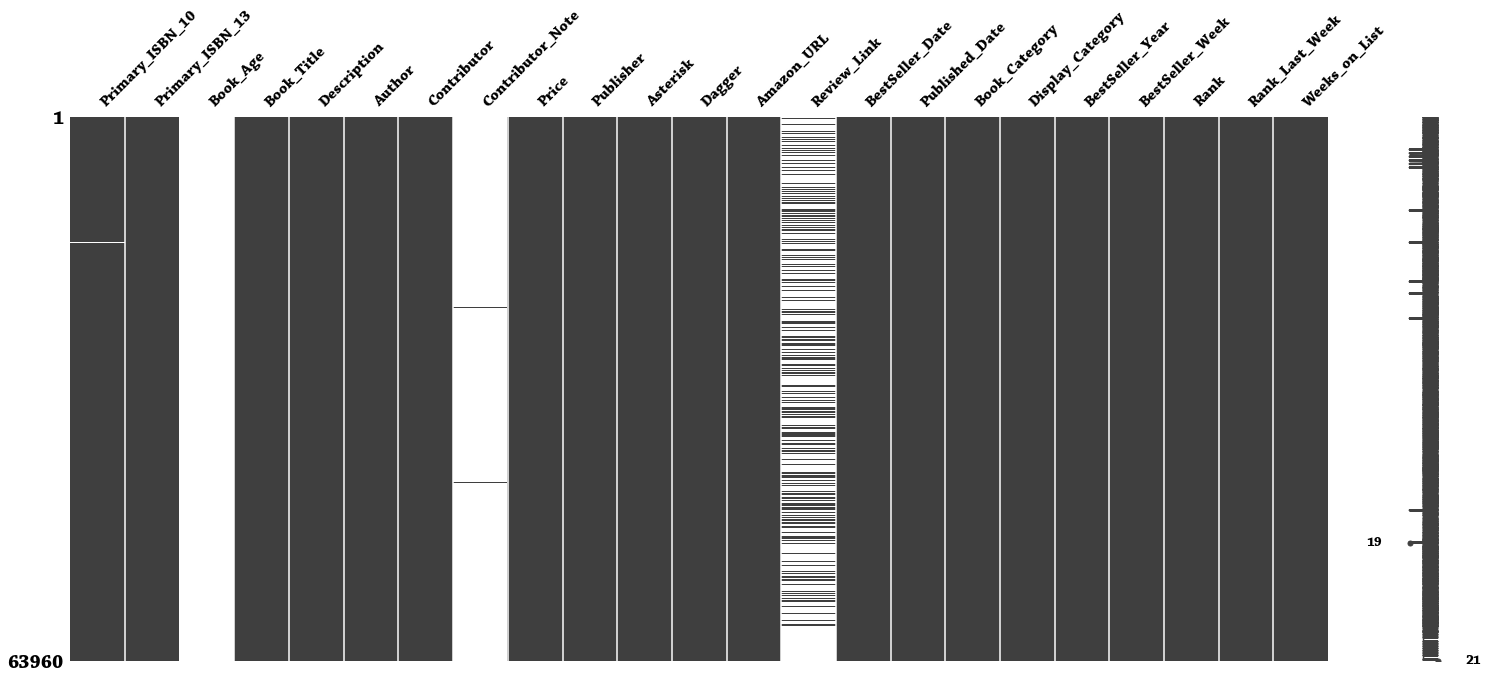

In [338]:
### Check for missing values ###
msn.matrix(nyt_bs_df)

In [340]:
### Check the Structure of the Data ###
print("Structure of the Data:\n")
nyt_bs_df.info()

Structure of the Data:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63960 entries, 0 to 63959
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Primary_ISBN_10   63862 non-null  object 
 1   Primary_ISBN_13   63960 non-null  object 
 2   Book_Age          0 non-null      float64
 3   Book_Title        63960 non-null  object 
 4   Description       63960 non-null  object 
 5   Author            63960 non-null  object 
 6   Contributor       63960 non-null  object 
 7   Contributor_Note  315 non-null    object 
 8   Price             63960 non-null  int64  
 9   Publisher         63960 non-null  object 
 10  Asterisk          63960 non-null  int64  
 11  Dagger            63960 non-null  int64  
 12  Amazon_URL        63960 non-null  object 
 13  Review_Link       20794 non-null  object 
 14  BestSeller_Date   63960 non-null  object 
 15  Published_Date    63960 non-null  object 
 16  Book_Category   

### Note from above data description and visuals:
1. From dataframe, we can see that there are 23 columns in total and not all are useful information. 
2. From Missing Valus matrix, Book_Age, Contributor_Note are fully missing. Thus, it can be removed. Review Link also has some missing values, but it doesn't matter as no sensible visualization can be performed on that variable.
3. A book can be found based on one ISBN. And since ISBN_13 has E+12 term, it's not useful.
4. Also, Book_Category and Display_Category is same, thus one can suffice

Thus, drop Book_Age, Contributor_Note, Primary_ISBN_13, and Display_Category

In [320]:
nyt_bs_df.drop(columns=["Book_Age","Contributor_Note","Primary_ISBN_13","Display_Category"], inplace=True)

### Check on numeric fields ###
print("Descriptive Statistics of the Numeric Columns:\n",nyt_bs_df.describe(), "\n")

         Price      Asterisk        Dagger  BestSeller_Year  BestSeller_Week  \
count  63960.0  63960.000000  63960.000000     63960.000000     63960.000000   
mean       0.0      0.007880      0.021232      2018.972795        25.911820   
std        0.0      0.088419      0.144158         0.810474        14.703362   
min        0.0      0.000000      0.000000      2018.000000         1.000000   
25%        0.0      0.000000      0.000000      2018.000000        13.000000   
50%        0.0      0.000000      0.000000      2019.000000        26.000000   
75%        0.0      0.000000      0.000000      2020.000000        39.000000   
max        0.0      1.000000      1.000000      2020.000000        52.000000   

               Rank  Rank_Last_Week  Weeks_on_List  
count  63960.000000    63960.000000   63960.000000  
mean       8.000000        4.662867      12.777439  
std        4.320528        4.479164      20.659875  
min        1.000000        0.000000       1.000000  
25%        4.0

### Note from above numeric data description:
1. Here for numeric variables, we can see that mean Rank in these 3 years is 8 and last week rank for the same book is 4.
2. As Book_Price column has price of all books as 0, it's not useful for us. 
3. bulk purchases appear with a dagger (†). => Might be useful.
4. An asterisk (*) indicates that a book's sales are barely distinguishable from those of the book above. => Might be useful.

For now, we drop Price Column

In [323]:
nyt_bs_df.drop(columns=["Price"], inplace=True)

### Including the rest columns makes this data suitable as a best selling book data. ###
nyt_bs_df.head(5)   ### Check the new data => It's Correct! ###

,Primary_ISBN_10,Book_Title,Description,Author,Contributor,Publisher,Asterisk,Dagger,Amazon_URL,Review_Link,BestSeller_Date,Published_Date,Book_Category,BestSeller_Year,BestSeller_Week,Rank,Rank_Last_Week,Weeks_on_List
0,385514239,ORIGIN,A symbology professor goes on a perilous quest...,Dan Brown,by Dan Brown,Doubleday,0,0,https://www.amazon.com/Origin-Novel-Dan-Brown-...,NaN,12/23/17,1/7/18,Combined Print and E-Book Fiction,2018,1,1,2,12
1,385541171,THE ROOSTER BAR,Three students at a sleazy for-profit law scho...,John Grisham,by John Grisham,Doubleday,0,0,https://www.amazon.com/Rooster-Bar-John-Grisha...,NaN,12/23/17,1/7/18,Combined Print and E-Book Fiction,2018,1,2,1,9
2,1449486797,THE SUN AND HER FLOWERS,A new collection of poetry from the author of ...,Rupi Kaur,by Rupi Kaur,Andrews McMeel,0,0,https://www.amazon.com/Sun-Her-Flowers-Rupi-Ka...,https://www.nytimes.com/2017/12/15/books/revie...,12/23/17,1/7/18,Combined Print and E-Book Fiction,2018,1,3,3,12
3,316273902,THE PEOPLE VS. ALEX CROSS,Detective Cross takes on a case even though he...,James Patterson,by James Patterson,"Little, Brown",0,0,https://www.amazon.com/People-vs-Alex-Cross/dp...,NaN,12/23/17,1/7/18,Combined Print and E-Book Fiction,2018,1,4,5,5
4,144947425X,MILK AND HONEY,Poetic approaches to surviving adversity and l...,Rupi Kaur,by Rupi Kaur,Andrews McMeel,0,0,http://www.amazon.com/Milk-Honey-Rupi-Kaur/dp/...,NaN,12/23/17,1/7/18,Combined Print and E-Book Fiction,2018,1,5,7,45


- We are cognizant that a same book can be repeated next week with some other rank, so we don't check for book duplicates. 
- Check for duplicates based on all columns => This means, a same book with same ranking is present in same week more than once

In [324]:
print("Total Duplicate rows considering all columns: ",len(nyt_bs_df[nyt_bs_df.duplicated()]), "\n")
unique_rows = len(nyt_bs_df) - len(nyt_bs_df[nyt_bs_df.duplicated()])
print("Total Unique Rows in the Data: ", unique_rows, "\n")

### We thus remove the duplicates for a proper visualization ###
nyt_bs_df.drop_duplicates(inplace=True)
if unique_rows == len(nyt_bs_df):
    print("Duplicates Removed !")

### Check our final structured Cleaned Data ###
nyt_bs_df.head(10) 

Total Duplicate rows considering all columns:  54660 

Total Unique Rows in the Data:  9300 

Duplicates Removed !


,Primary_ISBN_10,Book_Title,Description,Author,Contributor,Publisher,Asterisk,Dagger,Amazon_URL,Review_Link,BestSeller_Date,Published_Date,Book_Category,BestSeller_Year,BestSeller_Week,Rank,Rank_Last_Week,Weeks_on_List
0,385514239,ORIGIN,A symbology professor goes on a perilous quest...,Dan Brown,by Dan Brown,Doubleday,0,0,https://www.amazon.com/Origin-Novel-Dan-Brown-...,NaN,12/23/17,1/7/18,Combined Print and E-Book Fiction,2018,1,1,2,12
1,385541171,THE ROOSTER BAR,Three students at a sleazy for-profit law scho...,John Grisham,by John Grisham,Doubleday,0,0,https://www.amazon.com/Rooster-Bar-John-Grisha...,NaN,12/23/17,1/7/18,Combined Print and E-Book Fiction,2018,1,2,1,9
2,1449486797,THE SUN AND HER FLOWERS,A new collection of poetry from the author of ...,Rupi Kaur,by Rupi Kaur,Andrews McMeel,0,0,https://www.amazon.com/Sun-Her-Flowers-Rupi-Ka...,https://www.nytimes.com/2017/12/15/books/revie...,12/23/17,1/7/18,Combined Print and E-Book Fiction,2018,1,3,3,12
3,316273902,THE PEOPLE VS. ALEX CROSS,Detective Cross takes on a case even though he...,James Patterson,by James Patterson,"Little, Brown",0,0,https://www.amazon.com/People-vs-Alex-Cross/dp...,NaN,12/23/17,1/7/18,Combined Print and E-Book Fiction,2018,1,4,5,5
4,144947425X,MILK AND HONEY,Poetic approaches to surviving adversity and l...,Rupi Kaur,by Rupi Kaur,Andrews McMeel,0,0,http://www.amazon.com/Milk-Honey-Rupi-Kaur/dp/...,NaN,12/23/17,1/7/18,Combined Print and E-Book Fiction,2018,1,5,7,45
5,385543913,DARKER,Christian Grey's tormented and difficult pursu...,EL James,by E.L. James,Vintage,0,0,https://www.amazon.com/Darker-Fifty-Shades-Tol...,NaN,12/23/17,1/7/18,Combined Print and E-Book Fiction,2018,1,6,4,4
6,399593489,THE MIDNIGHT LINE,Jack Reacher tracks down the owner of a pawned...,Lee Child,by Lee Child,Delacorte,0,0,https://www.amazon.com/Midnight-Line-Jack-Reac...,https://www.nytimes.com/2017/11/08/books/revie...,12/23/17,1/7/18,Combined Print and E-Book Fiction,2018,1,7,6,7
7,553448129,ARTEMIS,A small-time smuggler living in a lunar colony...,Andy Weir,by Andy Weir,Crown,0,0,https://www.amazon.com/Artemis-Novel-Andy-Weir...,NaN,12/23/17,1/7/18,Combined Print and E-Book Fiction,2018,1,8,10,6
8,1250122953,YEAR ONE,When a pandemic strikes and the world spins in...,Nora Roberts,by Nora Roberts,St. Martin's,0,0,https://www.amazon.com/Year-One-Chronicles-Boo...,NaN,12/23/17,1/7/18,Combined Print and E-Book Fiction,2018,1,9,8,3
9,307887448,READY PLAYER ONE,"It’s 2044, life on a resource-depleted Earth h...",Ernest Cline,by Ernest Cline,Broadway,0,0,http://www.amazon.com/Ready-Player-One-Ernest-...,https://www.nytimes.com/2011/08/15/books/ready...,12/23/17,1/7/18,Combined Print and E-Book Fiction,2018,1,10,11,6


### Save this final structured clean data in local machine to then store it in PostGreSQL

In [325]:
nyt_bs_df.to_csv("NYT_BestSeller_Structured_Cleaned.csv")
print("Cleaned Structured Data File Saved!\n")

Cleaned Structured Data File Saved!



# Store the Cleaned Data into PostGreSQL

In [82]:
import psycopg2, datetime
import pandas.io.sql as sqlio 
import json, pandas as pd

def create_new_database(db_name):
    connection_success = 0   ### Not a successful connection ###
    try:
        dbConnection = psycopg2.connect(
            user = "dap",
            password = "dap",
            host = "192.168.56.30", 
            port = "5432",
            database = "postgres")
        dbConnection.set_isolation_level(0) ### AUTOCOMMIT ###
        dbCursor = dbConnection.cursor() 
        
        ### CREATE A DATABASE WITH GIVEN NAME ###
        dbCursor.execute('SELECT datname FROM pg_database;')
        db_list = dbCursor.fetchall()   ### List of all existing database ###
        if (db_name,) in db_list:
            dbCursor.execute('DROP DATABASE '+db_name+';')   ### Drop the database and create a new again if already exist to avoid errors ###
        dbCursor.execute('CREATE DATABASE '+db_name+';')
        print("Database", db_name, "created in PostGreSQL Successfully.\n")
        dbCursor.close()
    except (Exception, psycopg2.Error) as dbError :
        print ("Error while creating new Database in PostgreSQL: ", dbError,"\n")
    else:
        connection_success = 1
    finally:
        if connection_success == 1:
            dbConnection.close()

def connect_to_new_db(db_name):
    try:
        dbConnection = psycopg2.connect(
            user = "dap",
            password = "dap",
            host = "192.168.56.30", 
            port = "5432",
            database = db_name)
        dbConnection.set_isolation_level(0) ### AUTOCOMMIT ###
        dbCursor = dbConnection.cursor() 
        print("Successfully Connected to Database", db_name, ".\n")
    except (Exception, psycopg2.Error) as dbError :
        print ("Error while connecting to PostgreSQL",db_name,"Database: ", dbError,"\n")
    
    return dbConnection, dbCursor

def main():    
    ### Get the data from the CSV ###
    nyt_bs_df = pd.read_csv("NYT_BestSeller_Structured_Cleaned.csv")
    
    ### Set Database and Table name ###
    db_name = "nyt_bestseller"
    table_name = "nyt_bestseller"
    
    try:
        ### CREATE NEW DATABASE IN POSTGRESQL ###
        create_new_database(db_name)
        
        ### MAKE A NEW CONNECTION TO OUR NEWLY CREATED DATABASE ###
        nytConnection, nytCursor = connect_to_new_db(db_name)
        
        ### CREATE A NYT_BestSeller TABLE IN THE DATABASE ###
        createNYTTable = """
            CREATE TABLE """+table_name+"""(
                OBJECT_ID VARCHAR(20) PRIMARY KEY,
                Primary_ISBN_10 VARCHAR(15),
                Book_Title VARCHAR(255) NOT NULL,
                Description VARCHAR(555),
                Author VARCHAR(255),
                Contributor VARCHAR(255),
                Publisher VARCHAR(255),
                Asterisk integer,
                Dagger integer,
                Amazon_URL VARCHAR(1000),
                Review_Link VARCHAR(255),
                BestSeller_Date DATE,
                Published_Date DATE,
                Book_Category VARCHAR(255),
                BestSeller_Year integer,
                BestSeller_Week integer,
                Rank integer,
                Rank_Last_Week integer,
                Weeks_on_List integer
            );
            """
        nytCursor.execute(createNYTTable)
        print("Table "+table_name+" created in "+db_name+" Successfully!\n")
        
        ### INSERT A ROWS IN THE TABLE ###
        insertnyt_bs_book = "INSERT INTO "+table_name+" VALUES ('{}',"+"'{}',"*17+"'{}')"
        
        for n, row in nyt_bs_df.iterrows():
            ### Our date format store is Structured data file is m/d/yy, which needs to be changed to store it in DATE format in PostGreSQL. ###
            ### Thus, we change the format to general DATE format. ###
            row["BestSeller_Date"] = row["BestSeller_Date"][:-2] + '20' + row["BestSeller_Date"][-2:]
            row["Published_Date"] = row["Published_Date"][:-2] + '20' + row["Published_Date"][-2:]
            row["BestSeller_Date"] = str(datetime.datetime.strptime(row["BestSeller_Date"],'%m/%d/%Y').strftime('%Y-%m-%d'))
            row["Published_Date"] = str(datetime.datetime.strptime(row["Published_Date"],'%m/%d/%Y').strftime('%Y-%m-%d'))
            
            ### Removing "'" (apostrophe) if any from the book title, description, author, publisher, contributor so that the string will be accepted while inserting it in PostGreSQL. ###
            row["Book_Title"] = row["Book_Title"].replace("'", "")
            row["Description"] = row["Description"].replace("'", "")
            row["Author"] = row["Author"].replace("'", "")
            row["Contributor"] = row["Contributor"].replace("'", "")
            row["Publisher"] = row["Publisher"].replace("'", "")
            
            nytCursor.execute(insertnyt_bs_book.format(*row))
    
        nytConnection.commit()
        print("All the data stored into PostGreSQL in "+db_name+" Database in "+table_name+" Table !\n")
        
        nytCursor.close()
    except (Exception, psycopg2.Error) as dbError :
        print ("Error while connecting to PostgreSQL", dbError)
    finally:
        if(nytConnection): 
            nytConnection.close()
            
            
if __name__ == "__main__":
    main()

Database nyt_bestseller created in PostGreSQL Successfully.

Successfully Connected to Database nyt_bestseller .

Table nyt_bestseller created in nyt_bestseller Successfully!

All the data stored into PostGreSQL in nyt_bestseller Database in nyt_bestseller Table !



# Perform Visualization by retrieving data from our created PostGreSQL Database

In [326]:
import seaborn as sns, matplotlib.pyplot as plt
import psycopg2, datetime
import pandas.io.sql as sqlio 
import json, pandas as pd

def connect_retrieve_data_from_database(db_name, table_name):
    connection_success = 0   ### Not a successful connection ###
    print("Connecting to Database", db_name, "in PostGreSQL...\n")
    try:
        dbConnection = psycopg2.connect(
            user = "dap",
            password = "dap",
            host = "192.168.56.30", 
            port = "5432",
            database = db_name)
        dbConnection.set_isolation_level(0) ### AUTOCOMMIT ###
        dbCursor = dbConnection.cursor() 
        print("Successfully Connected to Database"+db_name+".\n")
        
        ### GET ALL THE ROWS FROM the Table ###
        sql = """
        SELECT *
        FROM
            """+table_name+""";
        """
        
        dataframe = sqlio.read_sql_query(sql, dbConnection)
        print("Data retrieved from Database "+db_name+" from Table "+table_name+"!\n")
        
        dbCursor.close()
    
    except (Exception, psycopg2.Error) as dbError :
        print ("Error while connecting to PostgreSQL: ", dbError,"\n")
    else:
        connection_success = 1
    finally:
        if connection_success == 1:
            dbConnection.close()

    return dataframe


In [327]:
### Set the database and table name ###
db_name = "nyt_bestseller"
table_name = "nyt_bestseller"

### Connect to PostGreSQL Database and Retrieve our cleaned data for Visualization ###
nyt_bs_data = connect_retrieve_data_from_database(db_name, table_name)
print("All the Visualization made is for 3Years of BestSelling Books Data.\n")

Connecting to Database nyt_bestseller in PostGreSQL...

Successfully Connected to Databasenyt_bestseller.

Data retrieved from Database nyt_bestseller from Table nyt_bestseller.

All the Visualization made is for 3Years of BestSelling Books Data.



## Perform Visualization:

In [328]:
plt.rcParams["figure.figsize"]=20,15  ### Have all plots of this size ###
font = {'family' : 'Chaparral Pro',   ### Have same font through out for consistency ###
    'size'   : 20}
plt.rc('font', **font)

###  Dominating Book Categories in BestSelling List every Year

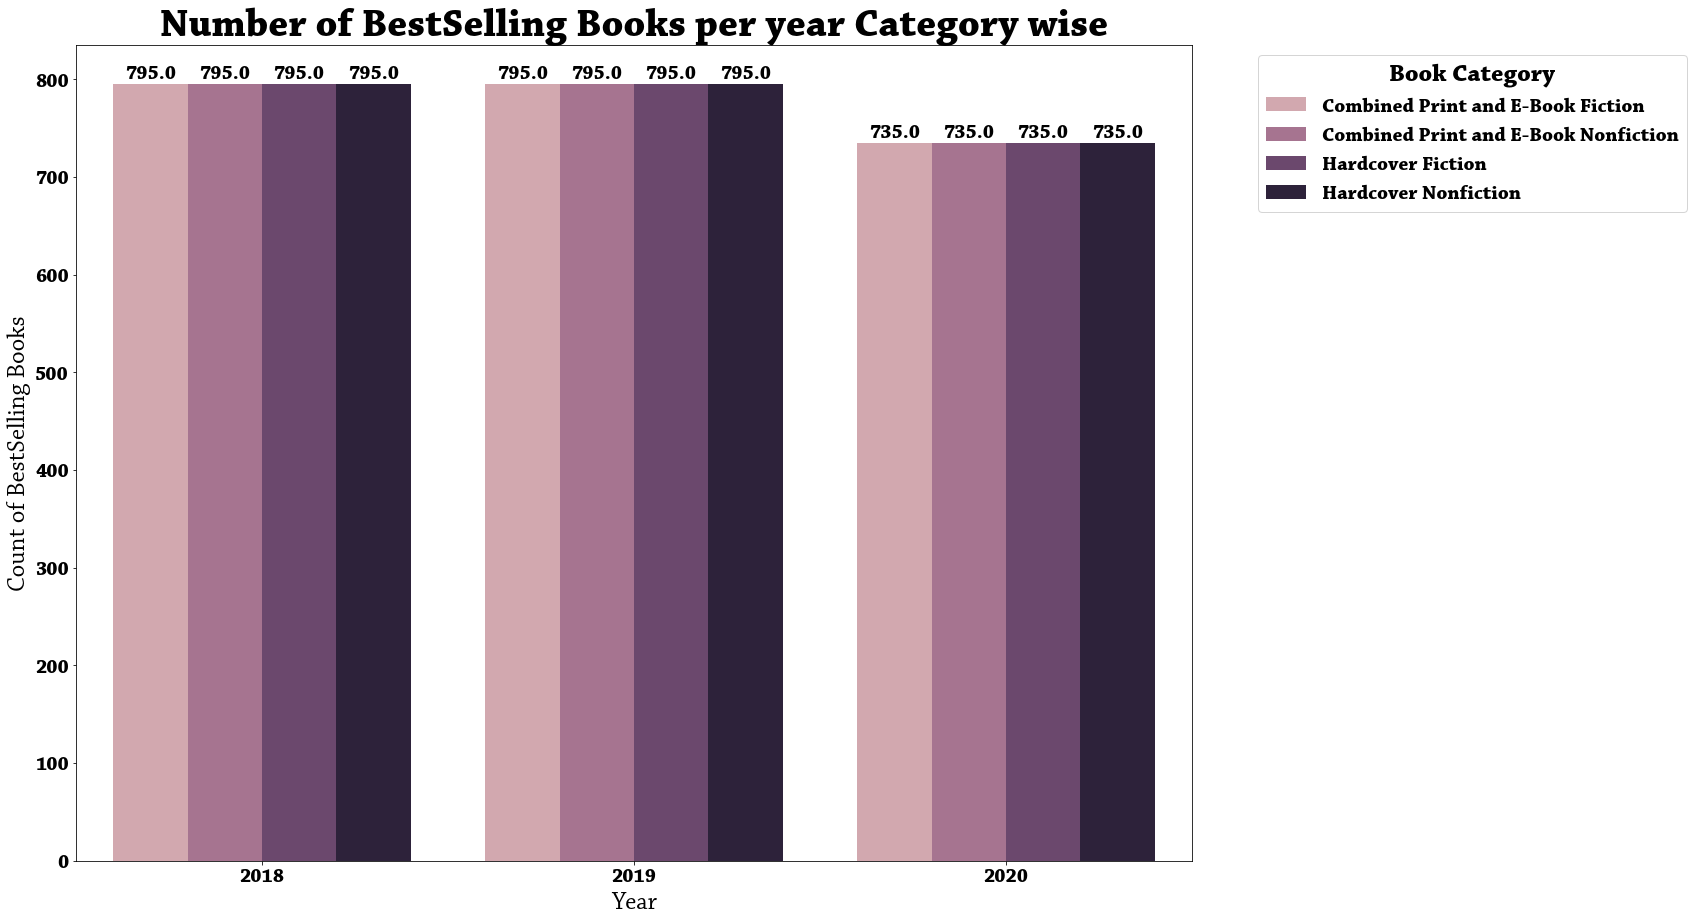

In [329]:
### Count Best Selling Categories every Year ###
grouped_cat_bsy_count = nyt_bs_data.groupby("bestseller_year")["book_category"].value_counts().reset_index(name="Count")
palette = sns.cubehelix_palette(light=.7, n_colors=4)
cat_plot = sns.barplot(x="bestseller_year", y="Count", hue="book_category", 
                       palette=palette, data=grouped_cat_bsy_count)
cat_plot.set_title("Number of BestSelling Books per year Category wise", fontsize=40, weight="bold")
for p in cat_plot.patches:
    height = p.get_height()
    cat_plot.annotate(p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
plt.legend(title='Book Category', title_fontsize='25', fontsize=20, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Year', fontsize=25)
plt.ylabel('Count of BestSelling Books', fontsize=25)
print("\n\n")
plt.show()
print("\n\n")

Above Graph Illustration:
- It is seen from the above graph that this data downloaded has all the books categories stored at equal numbers every year except for year 2020.
- Number of Best Selling Books for all 4 categories in our data for years 2018, and 2019 is 795 and for year 2020, it is 735.




### Which Author Has more BestSelling Books per Year from top 5 with count

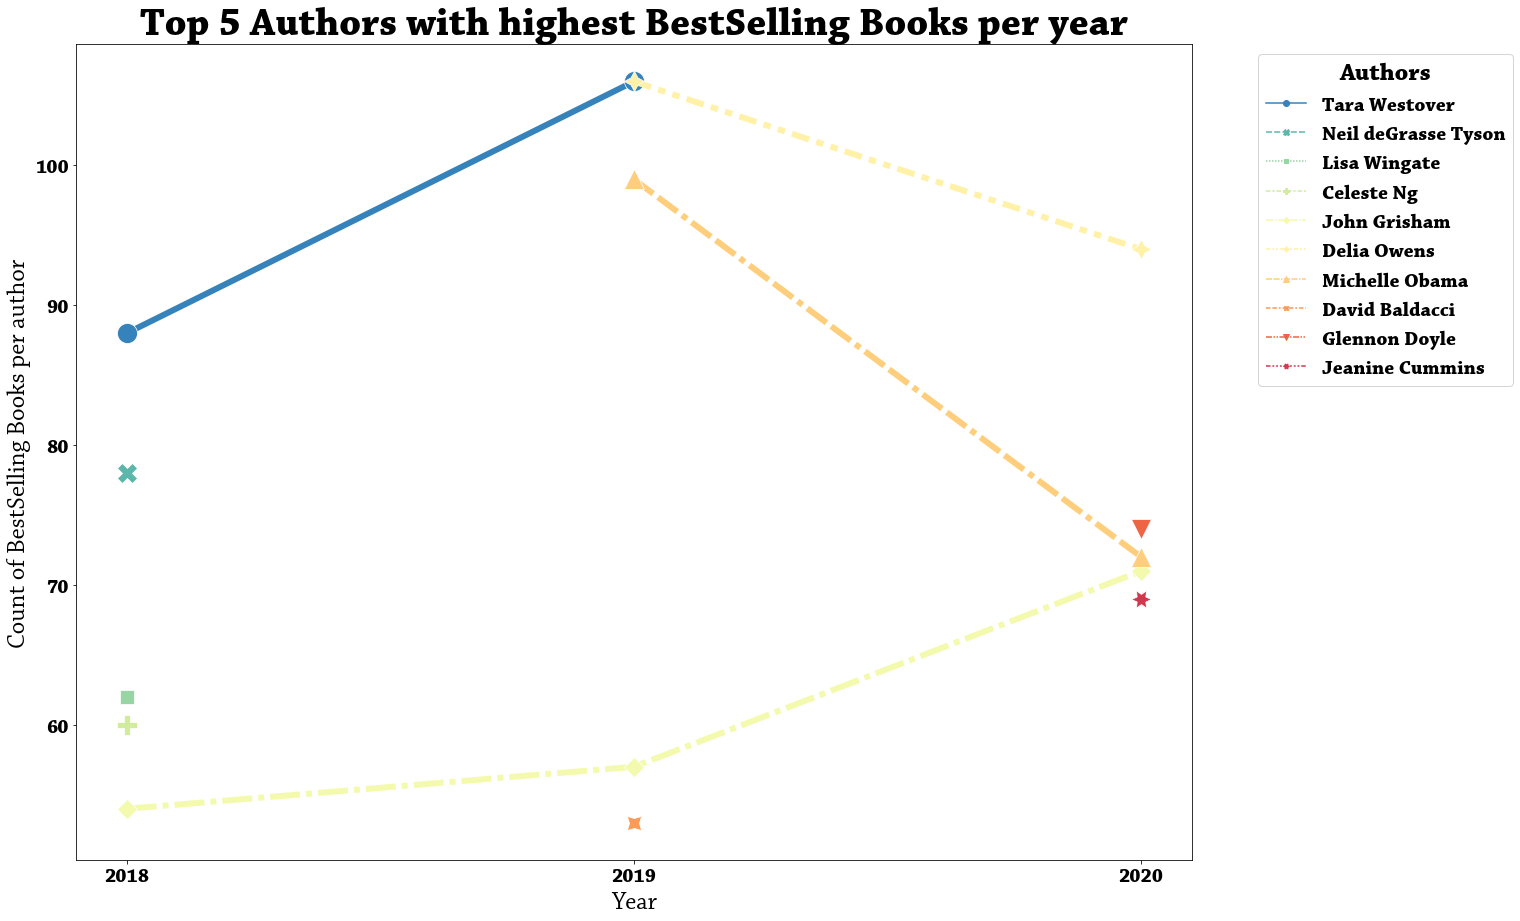

In [330]:
### Which Author Has more BestSelling Books per Year from top 5 with count ###
    
grouped_auth_bsy_count = nyt_bs_data.groupby("bestseller_year")["author"].value_counts().reset_index(name="Count")
grouped_auth_bsy_count_top_5 = grouped_auth_bsy_count.groupby(["bestseller_year"]).head(5)
palette = sns.color_palette("Spectral", 10)
palette.reverse()   ### Reverse the palette colors starting with blue ###
auth_plot = sns.lineplot(data=grouped_auth_bsy_count_top_5, x="bestseller_year", y="Count", hue="author", style="author",
    markers=True, dashes=True, linewidth=6, markersize=20, palette=palette)
auth_plot.set_title("Top 5 Authors with highest BestSelling Books per year", fontsize=40, weight="bold")
plt.legend(title='Authors', title_fontsize='25', fontsize=20, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(ticks=[2018,2019,2020],labels=["2018","2019", "2020"])
plt.xlabel('Year', fontsize=25)
plt.ylabel('Count of BestSelling Books per author', fontsize=25)
print("\n\n")
plt.show()
print("\n\n")

Above Graph Illustration:
- For Year 2018, Tara Westover with around 88 and Neil deGrasse Tyson around 78 were the first and second top bestselling Authors respectively.
- In Year 2019, Tara Westover again keeping up the highest mark with around 107 times being on the bestselling list for all her books. Delia Owens also had same count for total number of times being on the BestSelling list. Michelle Obama ranked 3rd with around score of just below 100 times for being on the BestSelling List.
- In Year 2020, Delia Owens maintained her top position from 2019 with score of around 95 times on BestSelling List whereas Glennon Doyle is second highest being around 74 times on the list. Michelle Obama, again this year, was 3rd on the list being just below Glennon Doyle around 72 times on the list.
- A continuos yearly increase is seen for author John Grisham in no. of times being on the bestselling list. In 2018, he ranked 5th being around 54 times where as in 2019 he ranked 4th with an increase of around 3-4 from last year. In 2020, he was just below Michelle Obama for number times being on the Best Selling List.
- The Lines are those individuals who managed to be consecutively in the top bestselling list over 2-3 years.

### Which top 20 Author's books(all) are on best selling week for longest period in total

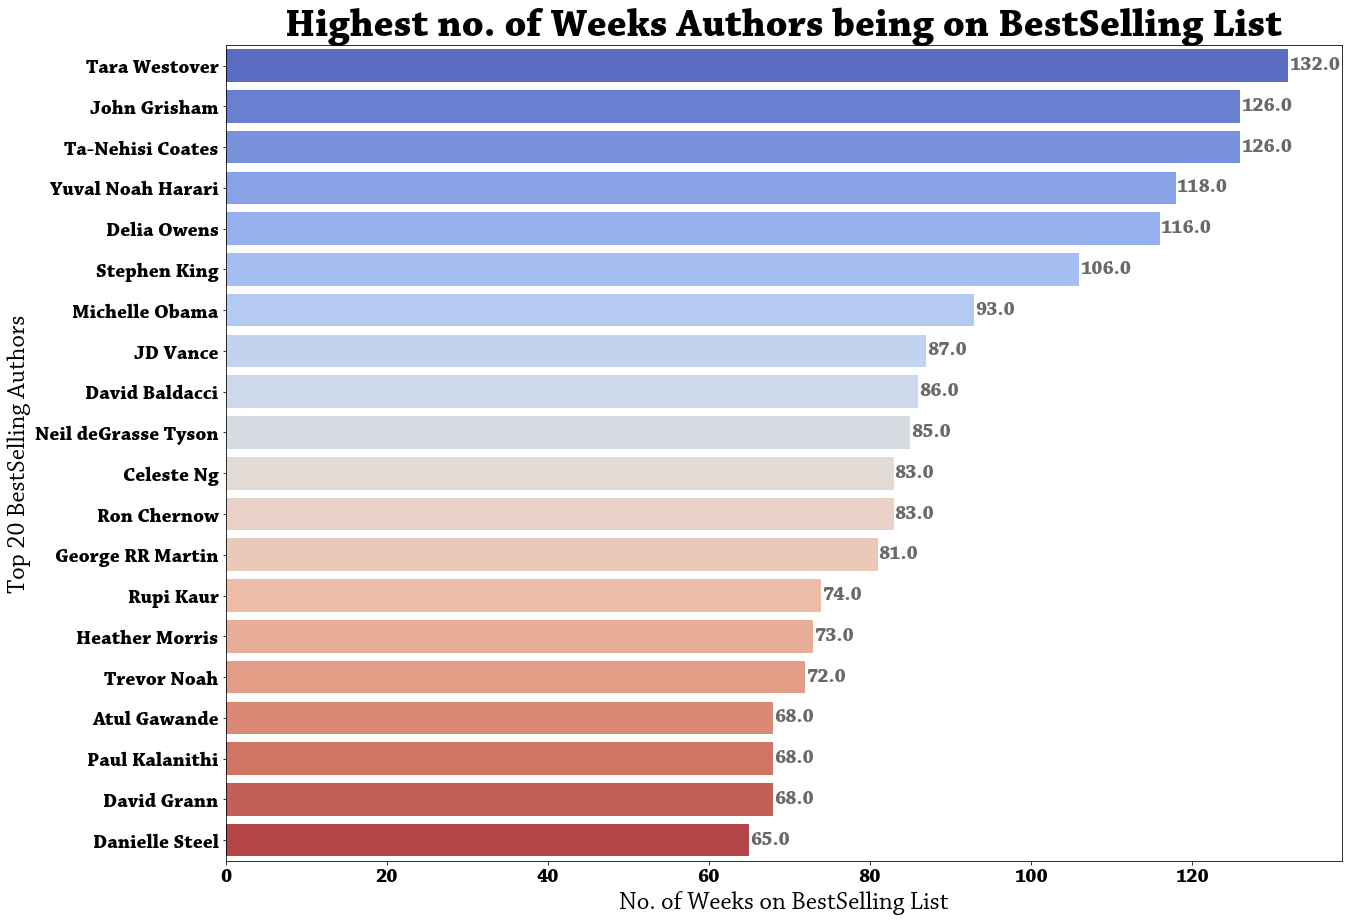

In [331]:
### Which top 20 Author's books(all) are on best selling week for longest period in total ###
    
grouped_auth_bs_wks_on_list_max = nyt_bs_data.groupby(["author","book_title"])["weeks_on_list"].max().reset_index(name="Max")
grouped_auth_bs_wks_on_list_total = grouped_auth_bs_wks_on_list_max.groupby("author")["Max"].sum().reset_index(name="Total").sort_values(by=["Total"], ascending=False).head(20)
palette = sns.color_palette("coolwarm", 20)
top_auth_plot = sns.barplot(x="Total", y="author",
            data=grouped_auth_bs_wks_on_list_total, palette=palette)
top_auth_plot.set_title("Highest no. of Weeks Authors being on BestSelling List", fontsize=40, weight="bold")
for p in top_auth_plot.patches:
    top_auth_plot.text(p.get_width()+.1, p.get_y()+.50, str(round((p.get_width()), 2)),
                       fontsize=20, color='dimgrey')
plt.xlabel('No. of Weeks on BestSelling List', fontsize=25)
plt.ylabel('Top 20 BestSelling Authors', fontsize=25)
print("\n\n")
plt.show()    
print("\n\n")

Above Graph Illustration:
- Out of all the 3 years, 2018-2020, it is seen that Tara Westover was the top author ranked 1 for being on the Best Selling List for 132 weeks in total.
- Second and Third position to secure are John Grisham and Ta-Nehisi Coates being 126 weeks on the BestSelling List.
- Yuval Noah Harari and Delia Owens were 118 and 116 weeks on the list standing 4th and 5th respectively.

### Which books showed up longest on the bestselling list (Top 15)

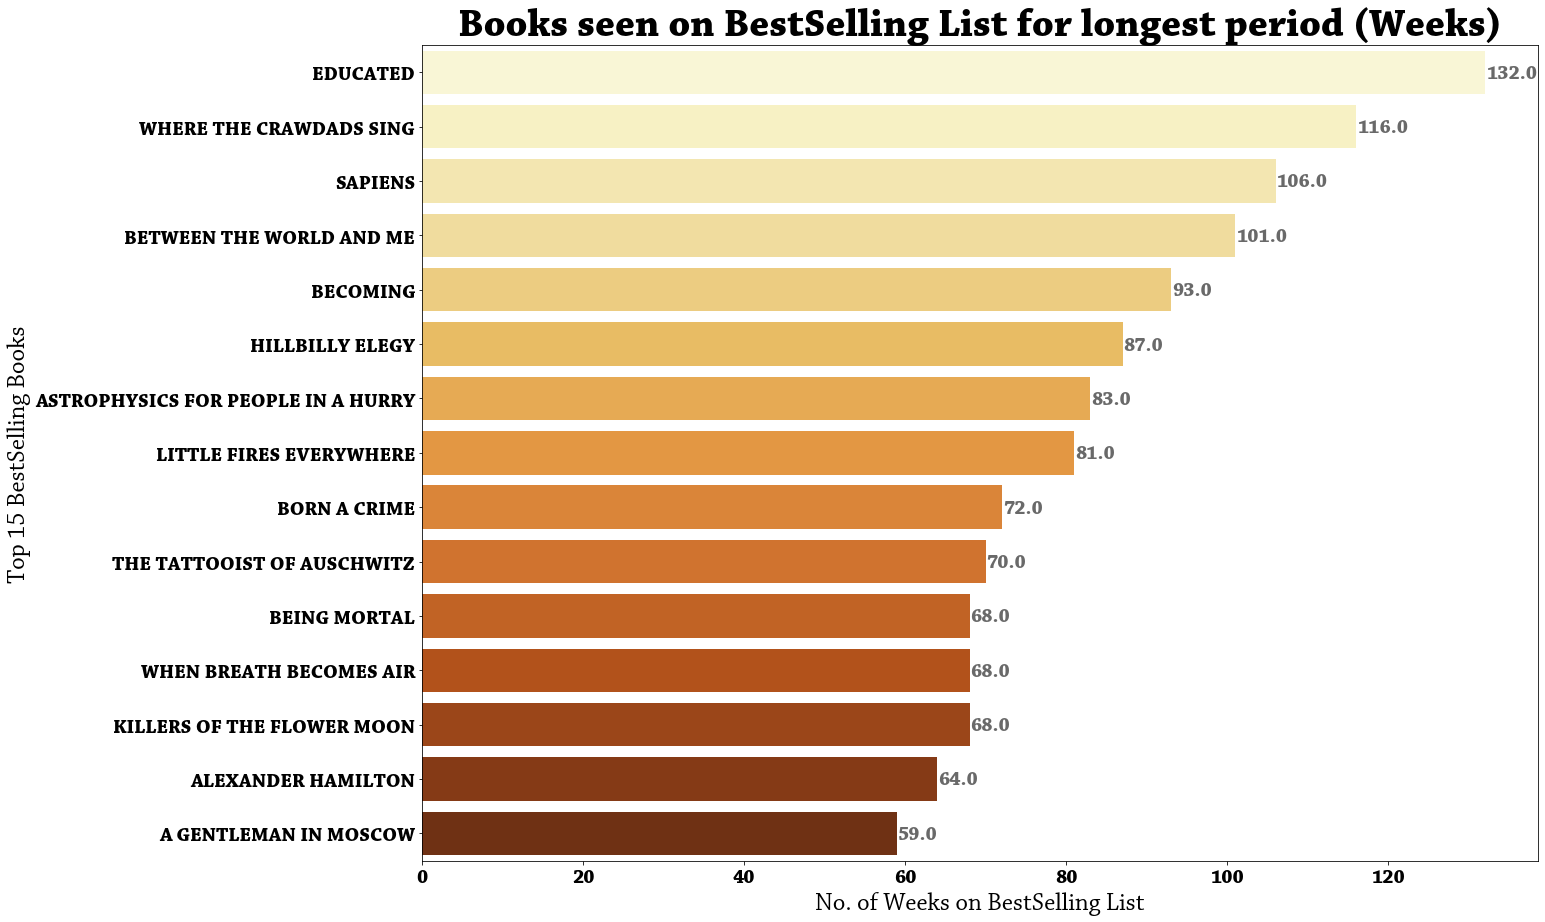

In [332]:
### Which books showed up longest on the bestselling list (Top 15) ###
    
grouped_books_bs_wks_on_list_max = nyt_bs_data.groupby(["book_title"])["weeks_on_list"].max().reset_index(name="Max").sort_values(by=["Max"], ascending=False).head(15)
palette = sns.color_palette("YlOrBr", 15)
top_books_plot = sns.barplot(x="Max", y="book_title",
            data=grouped_books_bs_wks_on_list_max, palette=palette)
top_books_plot.set_title("Books seen on BestSelling List for longest period (Weeks)", fontsize=40, weight="bold")
for p in top_books_plot.patches:
    top_books_plot.text(p.get_width()+.1, p.get_y()+.50, str(round((p.get_width()), 2)),
                       fontsize=20, color='dimgrey')
plt.xlabel('No. of Weeks on BestSelling List', fontsize=25)
plt.ylabel('Top 15 BestSelling Books', fontsize=25)
print("\n\n")
plt.show()    
print("\n\n")

Above Graph Illustration:
- For all these 3 years, Book named "Educated" is seen for the highest of 132 no. of weeks times on the BestSelling List.
- Second Book seen most of the time, 116 weeks, on the list is "Where The Crawdads Sing"

# THANK YOU :)